In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["font.sans-serif"] = ["SimHei"]

In [118]:
# read_excel
hs300_data = pd.read_excel(r"./000300.xlsx", index_col=0, header=4)
macro_data = pd.read_excel(r"./宏观数据.xlsx", index_col=0, header=9)
bond_data  = pd.read_excel(r"./bond.xlsx", index_col=0, header=3)
macro_bond_data = pd.read_excel(r"./macro.xlsx",index_col=0,header=1)

In [119]:
zz500_data = pd.read_excel(r"./zz500.xlsx",index_col=0,header=3)
zz1000_data = pd.read_excel(r"./zz1000.xlsx",index_col=0,header=3)

In [120]:
zz500_data = zz500_data["close"]
zz1000_data = zz1000_data["close"]

In [121]:
# direction config
stock_direction_dict = {
                        "PMI": 1,
                        "财新中国PMI":1,
                        "PPI:全部工业品:当月同比":-1,
                        "PPI预期误差":-1,
                        "CFETS人民币汇率指数":1,
                        "中间价:美元兑人民币":-1,
                        "中债企业债到期收益率(AA):1个月":-1,
                        "中债国开债到期收益率:10年":1,
                        "万得全A前一个月收益率":1,
                        "万得全A指数120日波动率":-1
                    }

bond_direction_dict = {
                    "PMI": -1,
                    "工业增加值预期误差": -1,
                    "CPI":-1,
                    "CFETS人民币汇率指数":1,
                    "中间价:美元兑人民币":-1,
                    "国债YTM_2y":-1,
                    "国债YTM_5y":-1,
                    "国债YTM_10y":-1,
                    "万得全A前一个月收益率":-1,
                    "万得全A指数120日波动率":1
}

backtest_config = {
                    "begin_date":"2006-01-31",
                    "end_date":"2022-01-31"
}

In [122]:
# data_cleaning
macro_data = macro_data.fillna(method="ffill")
macro_data["PPI预期误差"] = macro_data["PPI:全部工业品:当月同比"] - macro_data["万得一致预测:PPI:当月同比"]
macro_data["万得全A前一个月收益率"] = macro_data["万得全A"].dropna().resample("M").last().pct_change()
macro_data["万得全A指数120日波动率"] = macro_data["万得全A"].dropna().rolling(window=120).std()
stock_factor = macro_data[["PMI", "财新中国PMI","PPI:全部工业品:当月同比", "PPI预期误差","CFETS人民币汇率指数", "中间价:美元兑人民币","中债企业债到期收益率(AA):1个月", "中债国开债到期收益率:10年","万得全A前一个月收益率", "万得全A指数120日波动率"]].resample("M").last().fillna(1).pct_change().dropna(how="any")

macro_bond_data["工业增加值预期误差"] = macro_bond_data["工业增加值:当月同比"] - macro_bond_data["万得一致预测:工业增加值:当月同比"]
macro_bond_data = macro_bond_data.resample("M").last().fillna(1).pct_change().dropna(how="all").fillna(0)
macro_bond_data = macro_bond_data.loc["2003-01-31":"2023-01-31"]
macro_bond_data[["PMI","CFETS人民币汇率指数", "中间价:美元兑人民币","万得全A前一个月收益率", "万得全A指数120日波动率"]] = stock_factor[["PMI","CFETS人民币汇率指数", "中间价:美元兑人民币","万得全A前一个月收益率", "万得全A指数120日波动率"]].loc["2003-01-31":"2023-01-31"]
bond_factor = macro_bond_data[["PMI","工业增加值预期误差","CPI:当月同比","CFETS人民币汇率指数","中间价:美元兑人民币","中债国债到期收益率:2年","中债国债到期收益率:5年","中债国债到期收益率:10年","万得全A前一个月收益率", "万得全A指数120日波动率"]]

hs300_data = hs300_data.resample("M").last()
bond_data = bond_data.resample("M").last()
bond_data = bond_data["close"]
bond_data = bond_data.loc[backtest_config["begin_date"]:backtest_config["end_date"]]
hs300_data = hs300_data["收盘价"]
hs300_data = hs300_data.loc[backtest_config["begin_date"]:backtest_config["end_date"]]
hs300_return = hs300_data.pct_change()
bond_return = bond_data.pct_change()
zz500_data = zz500_data.resample("M").last()
zz500_data = zz500_data.loc[backtest_config["begin_date"]:backtest_config["end_date"]]
zz500_return = zz500_data.pct_change()
zz1000_data = zz1000_data.resample("M").last()
zz1000_data = zz1000_data.loc[backtest_config["begin_date"]:backtest_config["end_date"]]
zz1000_return = zz1000_data.pct_change()

In [123]:
hs300_data

日期
2006-01-31    1009.5970
2006-02-28    1053.0100
2006-03-31    1061.0880
2006-04-30    1172.3470
2006-05-31    1365.4510
                ...    
2021-09-30    4866.3826
2021-10-31    4908.7701
2021-11-30    4832.0260
2021-12-31    4940.3733
2022-01-31    4563.7720
Freq: M, Name: 收盘价, Length: 193, dtype: float64

In [124]:
# generate factor
def generate_factor(df, type):
    if type == "LS":
        df_temp = df.mask(df>0, 1)
        df_temp = df_temp.mask(df_temp<0, -1)
        return df_temp
    if type == "L":
        df_temp = df.mask(df>0, 1)
        df_temp = df_temp.mask(df_temp<0, 0)
        return df_temp    
    
def generate_sub_factor(df):
    df_temp = df.mask(df>0, 1)
    df_temp = df_temp.mask(df_temp<0, -1)
    return df_temp

# calculate_factor
def calculate_factor(df, type):
    if type == "S":
        direction_df = pd.Series(stock_direction_dict)
        factor_series = (df * direction_df).sum(axis=1)
        factor_series = factor_series.loc[backtest_config["begin_date"]:backtest_config["end_date"]]
        factor_series.index = hs300_data.index
        return factor_series.shift(1)
    if type == "B":
        direction_df = pd.Series(bond_direction_dict)
        factor_series = (df * direction_df).sum(axis=1)
        factor_series = factor_series.loc[backtest_config["begin_date"]:backtest_config["end_date"]]
        factor_series.index = bond_data.index
        return factor_series.shift(1)

# calculate_nav
def generate_nav(df, type, return_df, index_df):
    factor_df = pd.DataFrame()
    factor_df["long_short"] = generate_factor(df, type="LS")
    factor_df["long"] = generate_factor(df, type="L")
    if type =="S":
        factor_df = factor_df.multiply(return_df, axis=0)
        nav_df = (factor_df+1).cumprod()
        nav_df["index"] = index_df / index_df.iloc[0]
        return nav_df
    if type == "B":
        factor_df = factor_df.multiply(bond_return, axis=0)
        nav_df = (factor_df+1).cumprod()
        nav_df["index"] = bond_data / bond_data.iloc[0]
        return nav_df

# autowork
def auto_work(df, type, return_df, index_df):
    sub_factor_df = generate_sub_factor(df)
    factor_series = calculate_factor(sub_factor_df, type)
    nav_df = generate_nav(factor_series, type, return_df, index_df)
    return nav_df.dropna()


In [125]:
stock_nav_df = auto_work(stock_factor,"S", hs300_return, hs300_data)
bond_nav_df = auto_work(bond_factor, "B", hs300_return, hs300_data)

In [126]:
# backtest
def backtest(df, year=""):
    if year == "":
        nav_df = df
    else:
        nav_df = df[df.index.year==year]
    nav_pct_chg = (df/df.shift(1)-1)[1:]
    nav_detail = pd.DataFrame()
    nav_detail["open_date"] = nav_df.apply(lambda x:x.dropna().index[0])
    nav_detail["close_date"] = nav_df.apply(lambda x:x.dropna().index[-1])
    nav_detail["years_delta"] = (nav_detail["close_date"] - nav_detail["open_date"]).apply(lambda x:(x.days+1)/365)
    nav_detail["months"] = nav_df.count()
    nav_detail["return"] = nav_df.apply(lambda x: x[-1]/x[0]-1)
    nav_detail["return_per_year"] = (nav_detail["return"]+1)**(1/nav_detail["years_delta"])-1
    nav_detail["volatility_per_year"] = nav_pct_chg.std()*np.sqrt(1/nav_detail["years_delta"]*nav_detail["months"])
    nav_detail["Sharpe"] = (nav_detail["return_per_year"]) / nav_detail["volatility_per_year"]
    nav_detail["max_drawdown"] = 1-(nav_df/nav_df.cummax()).min()
    nav_detail["risk_profit_ratio"] = nav_detail["return_per_year"] / nav_detail["max_drawdown"]

    return nav_detail.T

In [127]:
backtest(stock_nav_df)

,long_short,long,index
open_date,2006-02-28 00:00:00,2006-02-28 00:00:00,2006-02-28 00:00:00
close_date,2022-01-31 00:00:00,2022-01-31 00:00:00,2022-01-31 00:00:00
years_delta,15.936986,15.936986,15.936986
months,192,192,192
return,45.896996,19.786398,3.334025
return_per_year,0.273091,0.209726,0.096385
volatility_per_year,0.278855,0.204715,0.29362
Sharpe,0.97933,1.024476,0.328265
max_drawdown,0.436699,0.242153,0.707542
risk_profit_ratio,0.625353,0.866086,0.136225


In [128]:
backtest(bond_nav_df)

,long_short,long,index
open_date,2006-02-28 00:00:00,2006-02-28 00:00:00,2006-02-28 00:00:00
close_date,2022-01-31 00:00:00,2022-01-31 00:00:00,2022-01-31 00:00:00
years_delta,15.936986,15.936986,15.936986
months,192,192,192
return,0.363009,0.521596,0.849787
return_per_year,0.019622,0.026689,0.039348
volatility_per_year,0.027623,0.024293,0.028711
Sharpe,0.71037,1.098592,1.370485
max_drawdown,0.053704,0.043092,0.044766
risk_profit_ratio,0.365383,0.619335,0.878982


<AxesSubplot:xlabel='日期'>

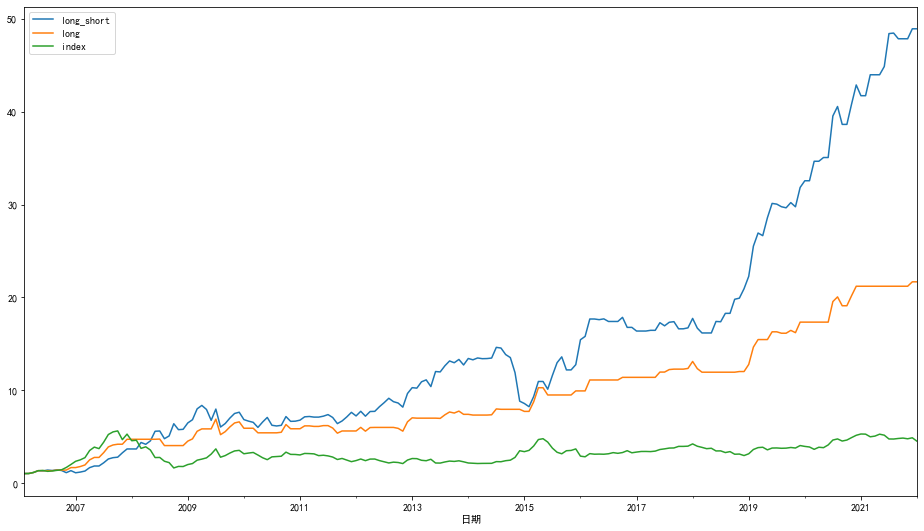

In [129]:
stock_nav_df.plot(figsize=(16,9))

<AxesSubplot:xlabel='Date'>

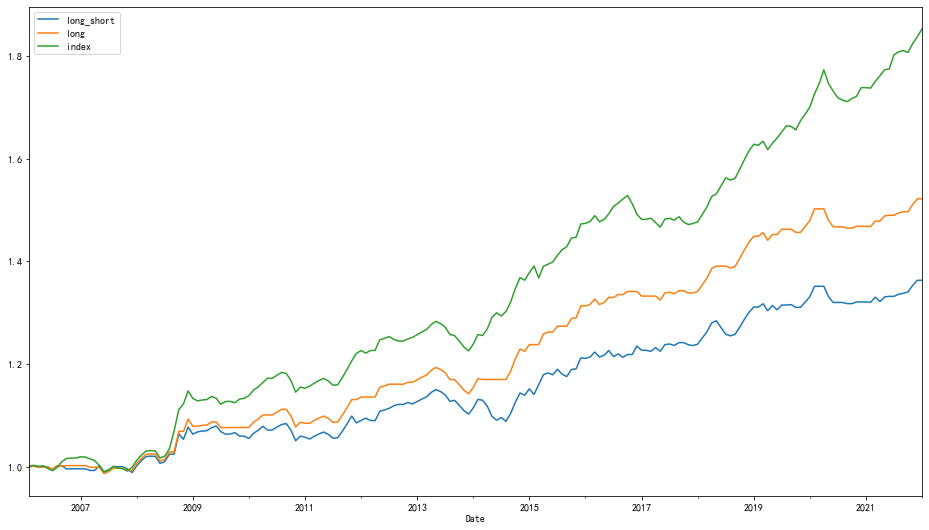

In [130]:
bond_nav_df.plot(figsize=(16,9))

In [131]:
stock_nav_df1 = auto_work(stock_factor,"S", zz500_return, zz500_data)
backtest(stock_nav_df1)

,long_short,long,index
open_date,2006-02-28 00:00:00,2006-02-28 00:00:00,2006-02-28 00:00:00
close_date,2022-01-31 00:00:00,2022-01-31 00:00:00,2022-01-31 00:00:00
years_delta,15.936986,15.936986,15.936986
months,192,192,192
return,115.115496,39.777156,5.821139
return_per_year,0.347615,0.26197,0.128034
volatility_per_year,0.302581,0.231563,0.326131
Sharpe,1.148833,1.131313,0.392584
max_drawdown,0.242603,0.235336,0.692736
risk_profit_ratio,1.432857,1.113176,0.184823


<AxesSubplot:xlabel='日期'>

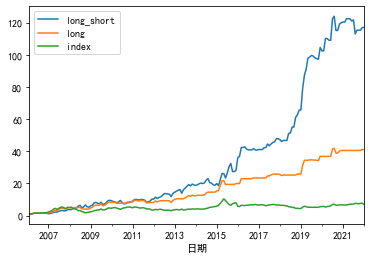

In [132]:
stock_nav_df1.plot()

In [133]:
stock_nav_df2 = auto_work(stock_factor,"S", zz1000_return, zz1000_data)
backtest(stock_nav_df2)

,long_short,long,index
open_date,2006-02-28 00:00:00,2006-02-28 00:00:00,2006-02-28 00:00:00
close_date,2022-01-31 00:00:00,2022-01-31 00:00:00,2022-01-31 00:00:00
years_delta,15.936986,15.936986,15.936986
months,192,192,192
return,126.801116,44.118403,6.502854
return_per_year,0.355748,0.270006,0.134796
volatility_per_year,0.327785,0.251819,0.357685
Sharpe,1.08531,1.072224,0.376858
max_drawdown,0.27265,0.256948,0.697246
risk_profit_ratio,1.30478,1.05082,0.193327


<AxesSubplot:xlabel='日期'>

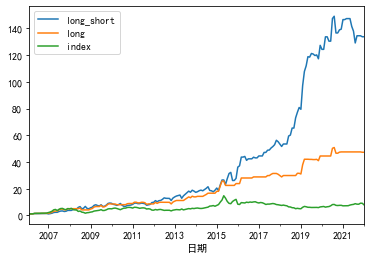

In [134]:
stock_nav_df2.plot()